In [2]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 

In [3]:
PATH = Path('data/lm/')

# Data preparation

The data format used in this notebook has changed, to comply with the new fastai API.

The new format is a CSV file with two columns:

- First column: text content to train the model. Here we have 100M words for the training data + 22M words for the validation data.
- Second column: Boolean representing if the data is for training or validation.

In [3]:
train = pd.read_csv(PATH/'train.csv', header=None, names=['label', 'content'])
valid = pd.read_csv(PATH/'valid.csv', header=None, names=['label', 'content'])

In [4]:
train['is_valid'] = False
valid['is_valid'] = True

In [5]:
df_train = train[['content', 'is_valid']]

In [6]:
df_valid = valid[['content', 'is_valid']]

In [8]:
df_train, df_valid

(                                                 content  is_valid
 0      Guerres civiles colombiennes\n\nLes guerres ci...     False
 1      Présidence de Nicolas Sarkozy\n\nLa présidence...     False
 2      Planification en république populaire de Chine...     False
 3      Worst Case Execution Time\n\nLe WCET ou Worst ...     False
 4      Église Saint-Denis de Mogneville\n\nL'église S...     False
 5      Église Saint-Denis de Remy\n\nL'église Saint-D...     False
 6      Église Sainte-Marie-Madeleine du Bellay-en-Vex...     False
 7      Église Sainte-Maxence de Pont-Sainte-Maxence\n...     False
 8      Église Saint-Didier de Villiers-le-Bel\n\nL'ég...     False
 9      Église Saint-Étienne de Marly-la-Ville\n\nL'ég...     False
 10     Église Sainte-Madeleine de Trie-Château\n\nL'é...     False
 11     Église Saint-Germain d'Andrésy\n\nL'église Sai...     False
 12     Église Saint-Germain-de-Paris de Cléry-en-Vexi...     False
 13     Église Saint-Gervais de Pontpoint\n\nL'é

In [9]:
df_regroup = pd.concat([df_train, df_valid])

In [10]:
df_regroup.to_csv(PATH/'fulltrain.csv', header=None, index=None)

# LM Training


We train two LM: one with a 60k vocabulary and one with a 30k vocabulary. The two models have different performance and computation needs.

In [4]:
PATH = Path('data/lm/')
tokenizer = Tokenizer(lang='fr', n_cpus=6)

In [12]:
data_lm_full = (TextList.from_csv(PATH, csv_name='fulltrain.csv', cols=0, processor=[TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=60000)])
           #Inputs: all the text files in path
            .split_from_df(col=1)
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=32))

In [13]:
data_lm_full.save('full_lm_60k')

In [8]:
data_lm_full = TextLMDataBunch.load(PATH, 'full_lm_60k', bs=32)

In [15]:
len(data_lm_full.train_ds.vocab.itos)

60002

In [17]:
data_lm_full.show_batch()



idx,text
0,"xxbos xxmaj entrée des états-unis dans la xxmaj première xxmaj guerre mondiale \n\n xxup l' entrée dans la xxmaj première xxmaj guerre mondiale des états-unis se produisit en avril 1917 , après deux ans et demi d' efforts déployés par le président xxmaj woodrow xxmaj wilson pour garder les états-unis neutres dans cette guerre . xxmaj exceptée une partie xxunk soutenant les xxmaj britanniques , l' opinion publique américaine était"
1,"il met alors l' accent sur le caractère forcément provisoire et éphémère de la première . \n « xxmaj si la religion est cet ensemble de vérités soumises à l’ intelligence humaine , la tentative de cette intelligence de les élucider , de les comprendre et surtout de les harmoniser intellectuellement de façon xxunk , se nomme théologie . xxmaj mais comprendre et harmoniser sont des opérations issues d’ une"
2,"mais xxmaj eastwood décide de réaliser le film en plus d' y interpréter le rôle du vieil entraîneur . xxmaj hilary xxmaj xxunk est embauchée pour jouer le rôle de la jeune xxunk et xxmaj morgan xxmaj freeman pour interpréter le gardien du gymnase , vieil ami de l' entraîneur . xxmaj le tournage a lieu à xxmaj los xxmaj angeles au début de l' année 2004 . xxmaj eastwood"
3,"abord celui qu' offrent les femmes de son foyer , son épouse et sa fille . xxmaj le statut d' infériorité qu' il leur octroie d' évidence implique que , la société accordant sa priorité aux mâles , l' aspect femelle de la nature se trouve moralement xxunk . xxmaj car les femmes ne représentent pas seulement la maternité , mais hors de cet attribut essentiel , xxmaj dombey se"
4,"si le grand-oncle de xxmaj sarah , xxmaj james xxmaj temple , a été reconnu coupable de régicide ) et leur loyauté à la couronne , comme celle des xxmaj churchill , se voit récompensée par un emploi à la xxmaj cour : en 1673 , xxmaj sarah a suivi sa sœur xxmaj frances à la résidence de la duchesse d' xxmaj york , xxmaj marie de xxmaj modène ,"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


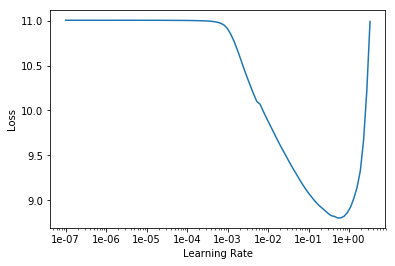

In [9]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=True, callback_fns=ShowGraph)
learn.lr_find()
learn.recorder.plot(skip_start=0)

Total time: 14:32:14
epoch  train_loss  valid_loss  accuracy
1      3.874567    3.998646    0.304150  (1:27:11)
2      3.636466    3.846859    0.310775  (1:27:01)
3      3.593106    3.822112    0.312760  (1:27:02)
4      3.584104    3.792033    0.314823  (1:27:45)
5      3.611241    3.744764    0.319751  (1:27:08)
6      3.562205    3.699586    0.325680  (1:27:09)
7      3.522145    3.659924    0.331840  (1:27:06)
8      3.563134    3.609655    0.339367  (1:27:27)
9      3.532401    3.576437    0.345281  (1:27:15)
10     3.486668    3.560602    0.347943  (1:27:00)



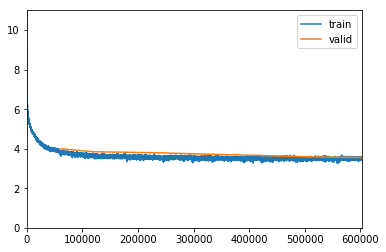

In [18]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=True, callback_fns=ShowGraph)
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))

Total time: 7:14:46
epoch  train_loss  valid_loss  accuracy
1      3.496704    3.712812    0.324994  (1:26:51)
2      3.444194    3.750016    0.320031  (1:26:56)
3      3.539182    3.681418    0.327540  (1:26:56)
4      3.480575    3.594445    0.340602  (1:27:00)
5      3.575246    3.552679    0.348032  (1:26:59)



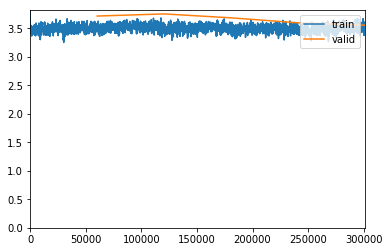

In [19]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

Total time: 1:28:47
epoch  train_loss  valid_loss  accuracy
1      3.489192    3.555320    0.348238  (1:28:46)



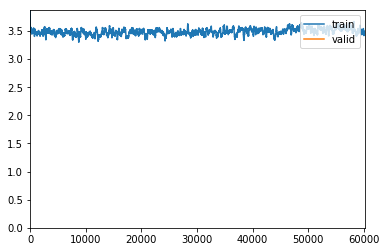

In [20]:
learn.fit_one_cycle(1, 2e-4, moms=(0.8,0.7))

In [21]:
learn.save('model-60k-vocab')

Now we train a model with a 30k vocabulary.
Because of this, batch size can be higher and training is quicker.

In [22]:
data_lm_full = (TextList.from_csv(PATH, csv_name='fulltrain.csv', cols=0, processor=[TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=30000)])
           #Inputs: all the text files in path
            .split_from_df(col=1)
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=64))

In [23]:
data_lm_full.save('full_lm_30k')

In [10]:
data_lm_full = TextLMDataBunch.load(PATH, 'full_lm_30k', bs=64)

In [6]:
len(data_lm_full.train_ds.vocab.itos)

30002

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


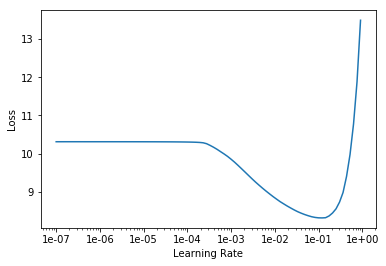

In [11]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=False, callback_fns=ShowGraph)
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [27]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=False, callback_fns=ShowGraph)

In [28]:
learn.fit_one_cycle(5, 1e-3)

Total time: 5:50:30
epoch  train loss  valid loss  accuracy
1      3.315902    3.501049    0.312577  (1:10:10)
2      3.340894    3.524558    0.308739  (1:10:03)
3      3.285287    3.471091    0.315308  (1:10:04)
4      3.265452    3.411206    0.323703  (1:10:10)
5      3.156996    3.377596    0.328114  (1:10:01)



The model perplexity is exp(validation loss):

In [7]:
np.exp(3.377596)

29.300248581579947

In [12]:
learn.save('model-30k-vocab')